In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('uber.csv')
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
data.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [5]:
data.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data.drop(['Unnamed: 0','key'], axis=1, inplace=True)

In [8]:
data = data[(data.pickup_latitude<90) & (data.dropoff_latitude<90) &
        (data.pickup_latitude>-90) & (data.dropoff_latitude>-90) &
        (data.pickup_longitude<180) & (data.dropoff_longitude<180) &
        (data.pickup_longitude>-180) & (data.dropoff_longitude>-180)]

In [9]:
data.pickup_datetime = pd.to_datetime(data.pickup_datetime)

In [10]:
data['year'] = data.pickup_datetime.dt.year
data['month'] = data.pickup_datetime.dt.month
data['weekday'] = data.pickup_datetime.dt.weekday
data['hour'] = data.pickup_datetime.dt.hour

data['Monthly_Quarter'] = data.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
data['Hourly_Segments'] = data.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})


In [11]:
data['distance'] = np.sqrt((data.dropoff_latitude - data.pickup_latitude)**2 + (data.dropoff_longitude - data.pickup_longitude)**2)*100

In [12]:
data.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_data = data.copy(deep=True)

data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1.513979
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2.210285
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5.310860
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1.652840
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,5.103138


In [13]:
data.drop(['pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude'],axis=1,inplace=True)

In [14]:
data = pd.get_dummies(data, drop_first=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199987 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         199987 non-null  float64
 1   passenger_count     199987 non-null  int64  
 2   year                199987 non-null  int32  
 3   weekday             199987 non-null  int32  
 4   distance            199987 non-null  float64
 5   Monthly_Quarter_Q2  199987 non-null  bool   
 6   Monthly_Quarter_Q3  199987 non-null  bool   
 7   Monthly_Quarter_Q4  199987 non-null  bool   
 8   Hourly_Segments_H2  199987 non-null  bool   
 9   Hourly_Segments_H3  199987 non-null  bool   
 10  Hourly_Segments_H4  199987 non-null  bool   
 11  Hourly_Segments_H5  199987 non-null  bool   
 12  Hourly_Segments_H6  199987 non-null  bool   
dtypes: bool(8), float64(2), int32(2), int64(1)
memory usage: 9.2 MB


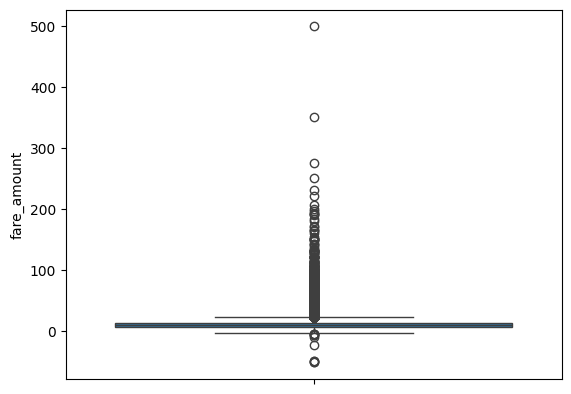

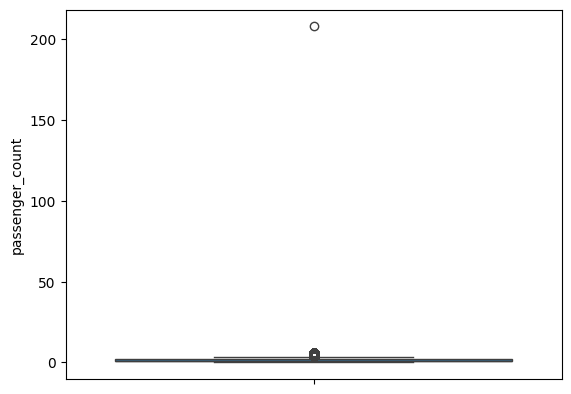

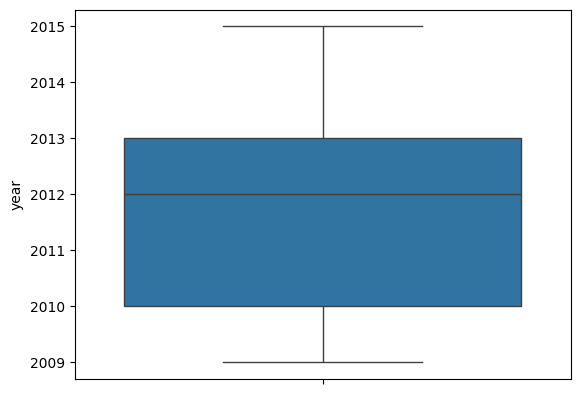

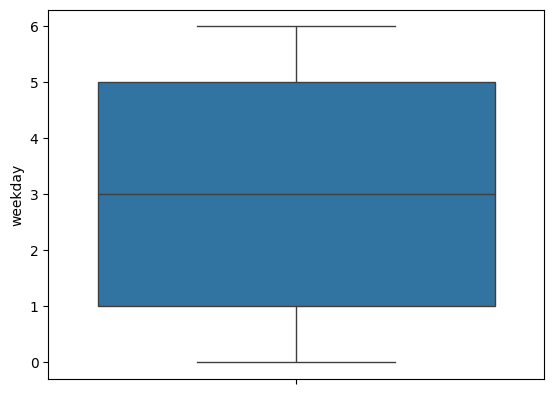

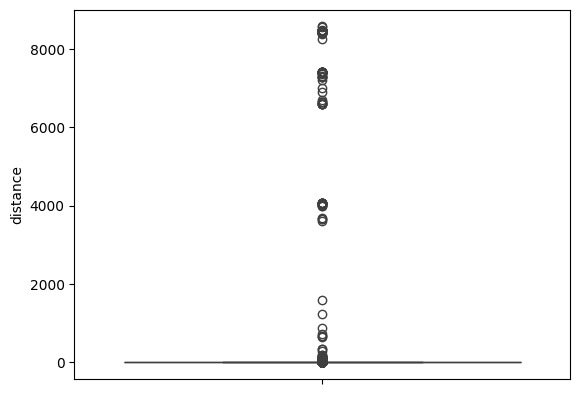

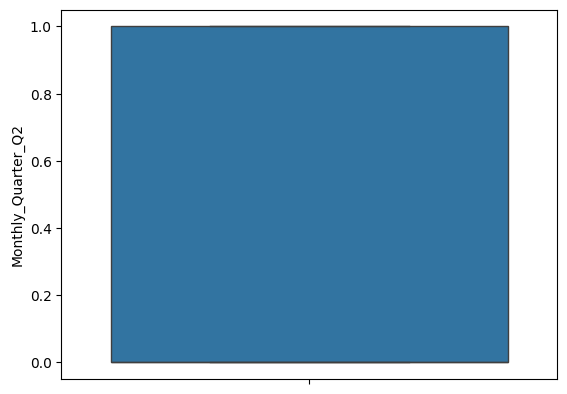

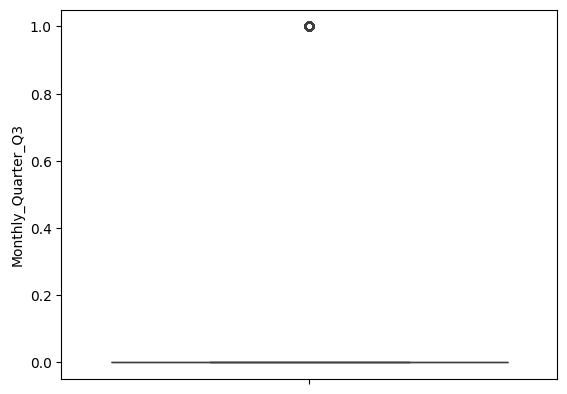

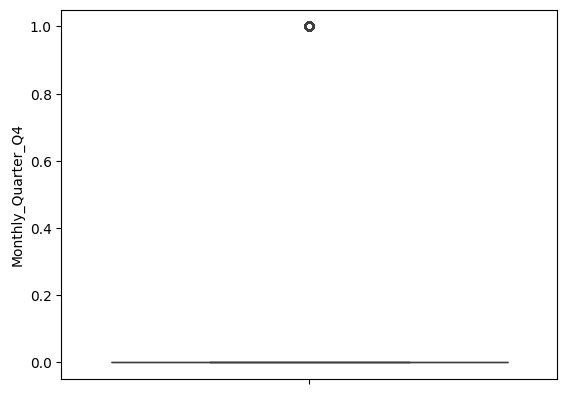

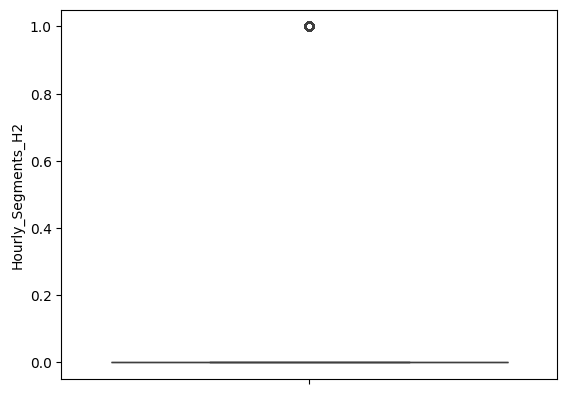

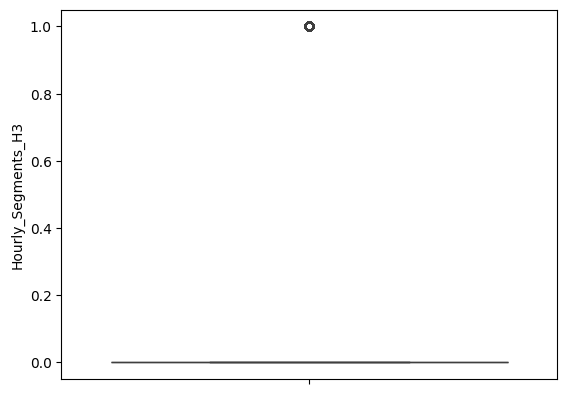

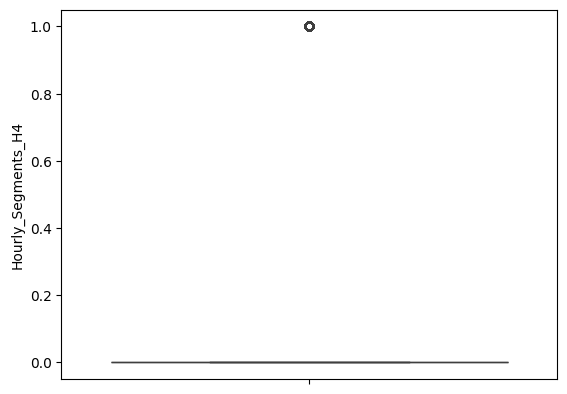

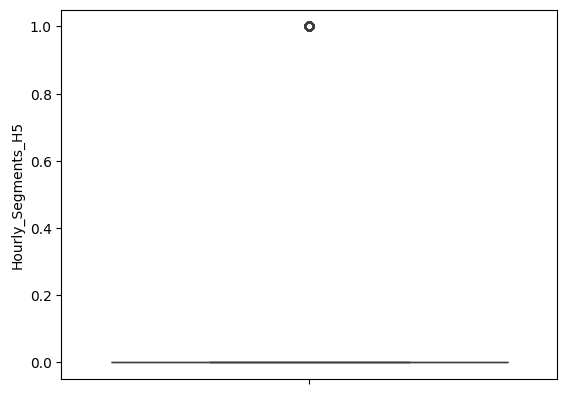

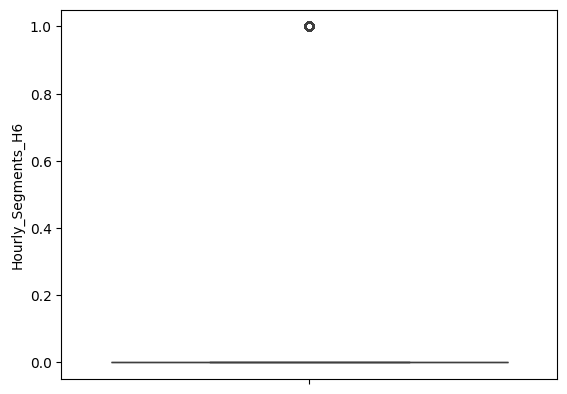

In [16]:
for feature in data.columns:
    sns.boxplot(data[feature])
    plt.show()

In [ ]:
for feature in ['fare_amount', 'distance']:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    data = data[(data[feature]>lower_bound) & (data[feature]<upper_bound)]

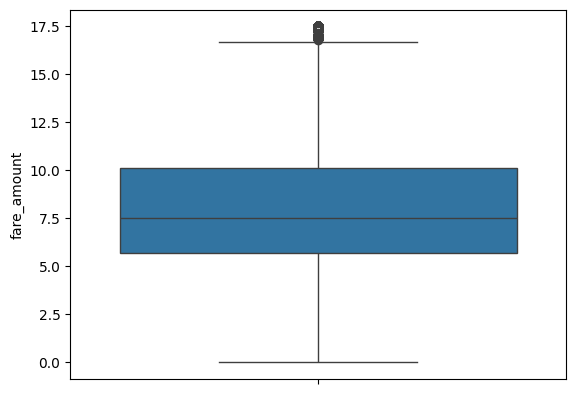

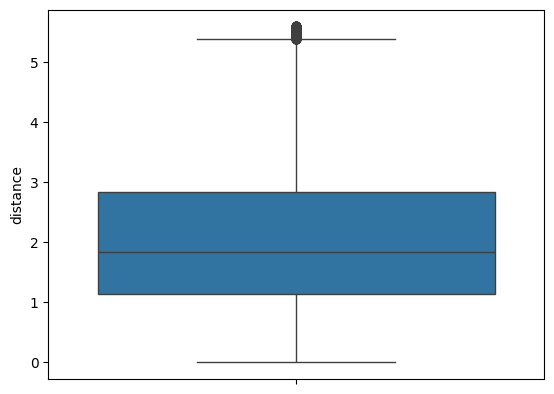

In [19]:
for feature in ['fare_amount', 'distance']:
    sns.boxplot(data[feature])
    plt.show()

In [20]:
X = data.drop('fare_amount', axis=1)
y = data['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


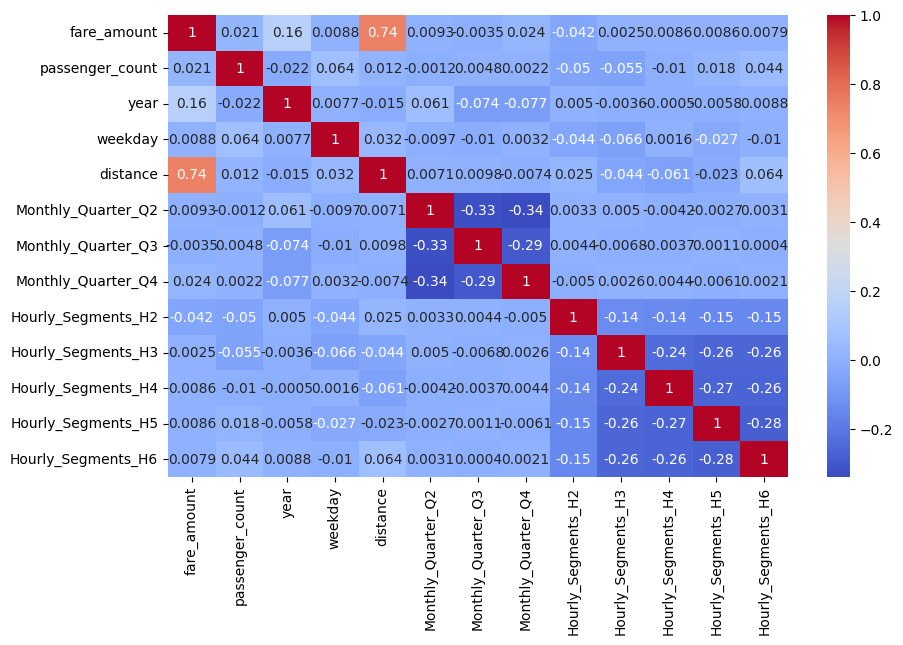

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Linear Regression')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))


Linear Regression
MSE: 4.117864909827736
R2 Score: 0.5976874356565698


In [25]:
print("Accuracy of the model is: ",model.score(X_test, y_test))

Accuracy of the model is:  0.5976874356565698


In [26]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 2.0292523031470817


In [27]:
ridge = Ridge(alpha = 0.1)
lasso = Lasso(alpha = 0.1)

In [28]:
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [29]:
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

In [30]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [31]:
mse_ridge, rmse_ridge, r2_ridge = evaluate_model(y_test, y_pred_ridge)
mse_lasso, rmse_lasso, r2_lasso = evaluate_model(y_test, y_pred_lasso)

print(f"Ridge Regression: MSE={mse_ridge}, RMSE={rmse_ridge}, R2={r2_ridge}")
print(f"Lasso Regression: MSE={mse_lasso}, RMSE={rmse_lasso}, R2={r2_lasso}")

Ridge Regression: MSE=4.117864968084639, RMSE=2.0292523175013595, R2=0.5976874299649105
Lasso Regression: MSE=4.225839942495056, RMSE=2.0556847867547825, R2=0.5871383493633838
